In [12]:
library(tidyverse, warn.conflict=F)
library(ggplot2)
library(dplyr)
library(data.table)
library(knitr) 
# library(corrplot)
library(ggcorrplot)
library(colorspace)
library(GGally)
library(extrafont)
# font_import()
# loadfonts(device = "pdf")

Warning message:
“패키지 ‘colorspace’는 R 버전 4.3.3에서 작성되었습니다”
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Registering fonts with R



In [13]:
mm2px <- function(mm){
    return(mm/25.4)
}

# Step 1. Load data

In [14]:
# load data
fn <- "/data/jerrylee/pjt/BIGFAM.v.0.1/paper/figures/data/vs_snp.filtered.tsv"
df <- fread(fn)

In [15]:
df_all <- df %>% select(-c("cohort", "pheno", "sig"))
df_sig <- df %>% filter(sig != "None") %>% select(-c("cohort", "pheno", "sig"))

In [16]:
c(nrow(df_all), nrow(df_sig))

[1] 23 19

In [55]:
# Custom stats function with R-squared instead of correlation
my_stats <- function(data, mapping, ...) {
  # Fit linear model
  fit <- lm(as.formula(paste(as.character(mapping$y)[2], "~", 
            as.character(mapping$x)[2])), data)
  
  # R-squared calculation
  r2 <- summary(fit)$r.squared
  
  # Calculate R-squared CI using bootstrap
  set.seed(123)
  n_boot <- 100
  r2_boot <- numeric(n_boot)
  
  for(i in 1:n_boot) {
    indices <- sample(1:nrow(data), replace = TRUE)
    boot_fit <- lm(as.formula(paste(as.character(mapping$y)[2], "~", 
                  as.character(mapping$x)[2])), data[indices,])
    r2_boot[i] <- summary(boot_fit)$r.squared
  }
  
  r2_ci <- quantile(r2_boot, c(0.025, 0.975))
  
  # Slope calculations
  slope <- coef(fit)[2]
  conf <- confint(fit)
  slope_ci <- conf[2,]
  slope_p <- summary(fit)$coefficients[2,4]
  
  # F-test p-value for overall model
  f_stat <- summary(fit)$fstatistic
  r2_p <- pf(f_stat[1], f_stat[2], f_stat[3], lower.tail = FALSE)
  
  # Add significance stars
  get_stars <- function(p) {
    if(p < 0.001) return("***")
    else if(p < 0.01) return("**")
    else if(p < 0.05) return("*")
    else return("")
  }
  
  r2_stars <- get_stars(r2_p)
  slope_stars <- get_stars(slope_p)
  
  # Create text label
  label <- sprintf(
    "R² = %.2f\n[%.2f, %.2f]%s\n\nslope = %.2f\n[%.2f, %.2f]%s",
    r2, r2_ci[1], r2_ci[2], r2_stars,
    slope, slope_ci[1], slope_ci[2], slope_stars
  )
  
  ggplot(data = data, mapping = mapping) + 
    annotate("text", x = 0.5, y = 0.65, 
             label = "",
             color = "#CD5C5C",
             size = 2.5,
             fontface = "bold") +
    # y 위치를 더 가깝게 조정
    annotate("text", x = 0.5, y = 0.52, 
             label = paste("R² = ", sprintf("%.2f", r2), r2_stars),
             color = "#CD5C5C",
             size = 2.5,
             fontface = "bold") +
    annotate("text", x = 0.5, y = 0.48,
             label = sprintf("[%.2f, %.2f]", r2_ci[1], r2_ci[2]),
             color = "#CD5C5C",
             size = 2) +
    annotate("text", x = 0.5, y = 0.38,
             label = paste("slope = ", sprintf("%.2f", slope), slope_stars),
             color = "#4682B4",
             size = 2.5,
             fontface = "bold") +
    annotate("text", x = 0.5, y = 0.34,
             label = sprintf("[%.2f, %.2f]", slope_ci[1], slope_ci[2]),
             color = "#4682B4",
             size = 2) +
    annotate("text", x = 0.5, y = 0.2, 
             label = "",
             color = "#CD5C5C",
             size = 2.5,
             fontface = "bold") +
    theme_void()
}

# Scatter plot with smaller tick labels
my_scatter <- function(data, mapping, ...) {
  ggplot(data = data, mapping = mapping) +
    geom_point(alpha = 0.4, size = 1.2, color = "#4682B4") +
    geom_smooth(
      method = "lm", 
      color = "#CD5C5C", 
      se = TRUE,
      fill = "#CD5C5C",
      alpha = 0.2
    ) +
    theme_bw() +
    theme(
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank()
    ) +
    scale_x_continuous(labels = scales::number_format(accuracy = 0.01)) +
    scale_y_continuous(labels = scales::number_format(accuracy = 0.01))
}

my_density <- function(data, mapping, ...) {
  ggplot(data = data, mapping = mapping) +
    geom_density(fill = "#69b3a2", alpha = 0.5) +
    theme_minimal()
}

# Create final plot
comparison_plot <- df_all %>% 
  select(BIGFAM, LDSC, Traditional, RDR) %>%
  drop_na() %>% 
  ggpairs(
    lower = list(continuous = my_scatter),
    diag = list(continuous = my_density),
    upper = list(continuous = my_stats)
  ) +
  theme_bw() +
  theme(
    axis.text = element_text(size = 5.6),  # 70% of original size
    strip.text = element_text(size = 9, face = "bold"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_rect(color = "black", fill = NA),
    strip.background = element_rect(fill = "white")
  )

In [56]:
# Save the plot
ggsave(
  filename = "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/test.pdf",
  plot = comparison_plot,
  width = 120,
  height = 120,
  units = "mm",
  dpi = 300    # 해상도
)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


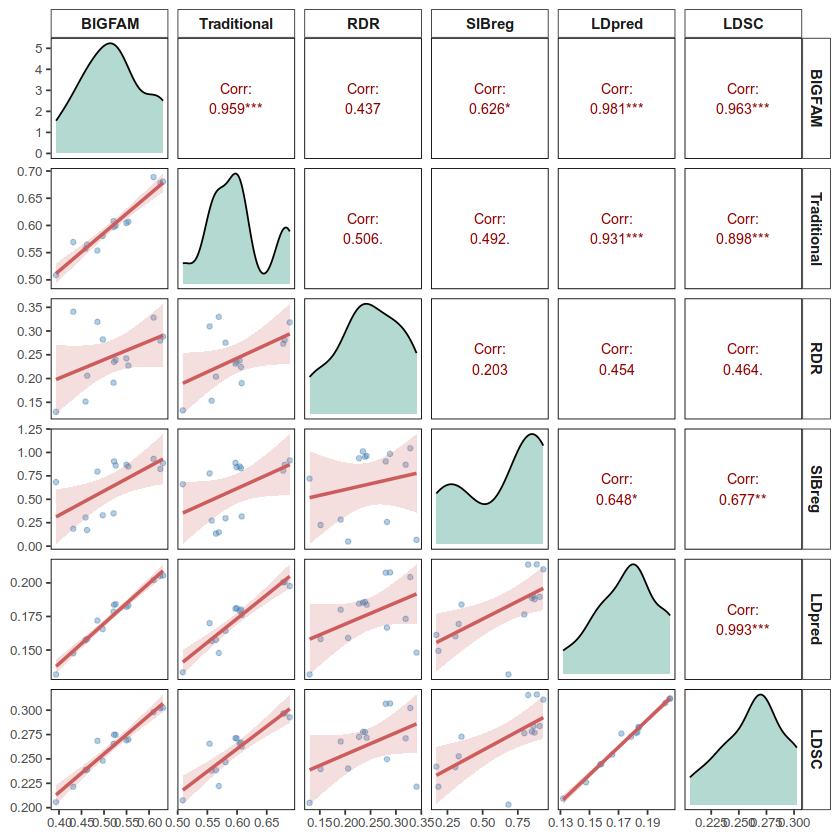

In [17]:

# Custom scatter plot with regression line and confidence interval
my_scatter <- function(data, mapping, ...) {
  ggplot(data = data, mapping = mapping) +
    geom_point(alpha = 0.4, size = 1.2, color = "#4682B4") +
    geom_smooth(
      method = "lm", 
      color = "#CD5C5C", 
      se = TRUE,
      fill = "#CD5C5C",
      alpha = 0.2
    ) +
    theme_bw() +  # 각 plot마다 테마 적용
    theme(
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank()
    )
}

# Custom correlation
my_cor <- function(data, mapping, ...) {
  ggally_cor(data, mapping, size = 3, color = "darkred") +
    theme_minimal()
}

# Custom density
my_density <- function(data, mapping, ...) {
  ggplot(data = data, mapping = mapping) +
    geom_density(fill = "#69b3a2", alpha = 0.5) +
    theme_minimal()
}

# Create pairplot
df_all %>% 
  drop_na() %>% 
  ggpairs(
    lower = list(continuous = my_scatter),
    diag = list(continuous = my_density),
    upper = list(continuous = my_cor)
  ) +
  theme_bw() +
  theme(
    axis.text = element_text(size = 8),
    strip.text = element_text(size = 9, face = "bold"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_rect(color = "black", fill = NA),
    strip.background = element_rect(fill = "white")
  )

In [11]:
library(tidyverse)
library(GGally)
library(extrafont)

# Helper function for complete axis lines
add_all_axis_lines <- function(p) {
  p + 
    theme(
      axis.line.x = element_line(color = "black", size = 0.3),
      axis.line.y = element_line(color = "black", size = 0.3),
      axis.ticks = element_line(color = "black", size = 0.3),
      panel.border = element_rect(color = "black", fill = NA, size = 0.3),
      panel.grid = element_blank(),
      panel.background = element_rect(fill = "white", color = NA),
      plot.background = element_rect(fill = "white", color = NA)
    )
}

# Custom scatter plot with regression (upper right)
my_upper <- function(data, mapping, ...) {
  x_var <- rlang::get_expr(mapping$x)
  y_var <- rlang::get_expr(mapping$y)
  
  # Fit linear model
  lm_fit <- lm(data[[y_var]] ~ data[[x_var]])
  slope <- coef(lm_fit)[2]
  slope_se <- summary(lm_fit)$coefficients[2, 2]
  
  x_range <- range(data[[x_var]], na.rm = TRUE)
  y_range <- range(data[[y_var]], na.rm = TRUE)
  x_pad <- diff(x_range) * 0.15
  y_pad <- diff(y_range) * 0.15
  
  p <- ggplot(data = data, mapping = mapping) +
    geom_point(
      size = 3.0,
      color = "#4477AA"
    ) +
    geom_smooth(
      method = "lm",
      color = "#E64B35",
      se = FALSE,
      size = 0.8
    ) +
    annotate(
      "text",
      x = x_range[1] + diff(x_range) * 0.3,
      y = y_range[2] + y_pad/2,
      label = sprintf("slope = %.2f(%.2f)", slope, slope_se),
      size = 3.5,
      family = "Arial"
    ) +
    coord_cartesian(
      xlim = c(x_range[1] - x_pad, x_range[2] + x_pad),
      ylim = c(y_range[1] - y_pad, y_range[2] + y_pad)
    ) +
    theme_minimal() +
    theme(
      axis.text = element_text(size = 10, color = "black")
    )
  
  add_all_axis_lines(p)
}

# Custom KDE plot with R-squared (lower left)
my_lower <- function(data, mapping, ...) {
  x_var <- rlang::get_expr(mapping$x)
  y_var <- rlang::get_expr(mapping$y)
  
  # Calculate correlation and p-value
  cor_test <- cor.test(data[[x_var]], data[[y_var]], use = "complete.obs")
  r_squared <- cor_test$estimate^2
  p_value <- cor_test$p.value
  
  # Add significance stars
  stars <- if(p_value < 0.001) "***"
          else if(p_value < 0.01) "**"
          else if(p_value < 0.05) "*"
          else ""
  
  x_range <- range(data[[x_var]], na.rm = TRUE)
  y_range <- range(data[[y_var]], na.rm = TRUE)
  x_pad <- diff(x_range) * 0.15
  y_pad <- diff(y_range) * 0.15
  
  p <- ggplot(data = data, mapping = mapping) +
    stat_density_2d(
      aes(fill = after_stat(level)),
      geom = "polygon",
      alpha = 0.7,
      bins = 10,
      color = NA
    ) +
    stat_density_2d(
      color = "#4477AA",
      bins = 10,
      size = 0.5,
      alpha = 0.8
    ) +
    scale_fill_gradient(low = "white", high = "#4477AA") +
    coord_cartesian(
      xlim = c(x_range[1] - x_pad, x_range[2] + x_pad),
      ylim = c(y_range[1] - y_pad, y_range[2] + y_pad)
    ) +
    annotate(
      "text",
      x = x_range[1] + diff(x_range) * 0.3,
      y = y_range[2] + y_pad/2,
      label = sprintf("R² = %.2f%s", r_squared, stars),
      size = 3.5,
      family = "Arial"
    ) +
    theme_minimal() +
    theme(
      legend.position = "none",
      axis.text = element_text(size = 10, color = "black")
    )
  
  add_all_axis_lines(p)
}

# Custom histogram for diagonal
my_diag <- function(data, mapping, ...) {
  x_var <- rlang::get_expr(mapping$x)
  x_range <- range(data[[x_var]], na.rm = TRUE)
  x_pad <- diff(x_range) * 0.15
  
  p <- ggplot(data = data, mapping = mapping) +
    geom_histogram(
      aes(y = after_stat(density)),
      bins = 30,
      fill = "gray80",
      color = "gray30",
      size = 0.2
    ) +
    geom_density(
      color = "black",
      size = 0.7,
      alpha = 1
    ) +
    coord_cartesian(
      xlim = c(x_range[1] - x_pad, x_range[2] + x_pad)
    ) +
    theme_minimal() +
    theme(
      axis.text = element_text(size = 10, color = "black")
    )
  
  add_all_axis_lines(p)
}

# Create pairplot
p <- df_all %>% 
  drop_na() %>% 
  ggpairs(
    upper = list(continuous = my_upper),
    lower = list(continuous = my_lower),
    diag = list(continuous = my_diag)
  ) +
  theme(
    text = element_text(family = "Arial"),
    strip.text = element_text(
      size = 12,
      face = "bold"
    ),
    strip.background = element_rect(
      fill = "white", 
      color = NA
    ),
    panel.spacing = unit(1, "lines"),
    plot.background = element_rect(fill = "white", color = NA),
    axis.title = element_blank()
  )

# Save plot
ggsave(
    "/data/jerrylee/pjt/BIGFAM.v.0.1/paper/figures/pairplot.pdf",
    plot = p,
    width = 12,
    height = 12,
    dpi = 300,
    units = "in"
)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
